In [1]:
# https://rfchallenge.mit.edu/challenge-3/

In [2]:
!wget https://rfchallenge.mit.edu/wp-content/uploads/2021/07/Cyber-RF_Anomaly_Detector_Challenge_Dataset_TrainingSet_80.csv

--2023-05-22 22:06:35--  https://rfchallenge.mit.edu/wp-content/uploads/2021/07/Cyber-RF_Anomaly_Detector_Challenge_Dataset_TrainingSet_80.csv
Resolving rfchallenge.mit.edu (rfchallenge.mit.edu)... 18.25.16.5
Connecting to rfchallenge.mit.edu (rfchallenge.mit.edu)|18.25.16.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363402 (355K) [text/csv]
Saving to: ‘Cyber-RF_Anomaly_Detector_Challenge_Dataset_TrainingSet_80.csv.1’

Cyber-RF_Anomaly_De 100%[===================>] 354.88K  --.-KB/s    in 0.09s   

2023-05-22 22:06:35 (3.93 MB/s) - ‘Cyber-RF_Anomaly_Detector_Challenge_Dataset_TrainingSet_80.csv.1’ saved [363402/363402]



In [1]:
import base64
import json

from kafka import KafkaProducer
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tritonclient.http as httpclient
import xgboost as xgb

Load data

In [2]:
df = pd.read_csv('Cyber-RF_Anomaly_Detector_Challenge_Dataset_TrainingSet_80.csv')

In [3]:
df.head()

,Amp_min,Amp_max,Amp_var,Amp_skew,Amp_rango,Amp_Kurtosis,Amp_entropy,Phase_min,Phase_var,Phase_skew,...,numPktSent_avg,NoBytesSnt_avg,minPktSize_min,maxPktSize_max,avgPktSz_avg,pktps_avg,bytps_avg,maxIAT_max,avgIAT_avg,Class
0,0.002581,0.690256,0.001211,15.12232,0.690256,240.0694,0.074172,0.090118,3.381202,0.038622,...,112,5615.0,17,51,50.13393,1.003314,50.30009,1.671043,0.996696,anomalous
1,0.003153,0.848947,0.001835,14.98176,0.848947,234.9678,0.074256,0.100556,3.374530,0.028128,...,113,5698.0,49,51,50.42478,1.012288,51.04442,1.669502,0.987861,anomalous
2,0.002031,0.410564,0.000674,13.88586,0.410564,194.0342,0.071829,0.094839,3.399020,0.033839,...,113,5766.0,50,52,51.02655,1.008791,51.47511,1.004366,0.991286,normal
3,0.003371,1.206924,0.002163,15.24407,1.206924,246.8864,0.069905,-0.083725,4.067368,0.188521,...,113,5709.0,49,51,50.52213,1.011909,51.12378,1.431243,0.988232,anomalous
4,0.002116,0.425429,0.000730,13.87303,0.425429,193.6966,0.072375,-0.204406,3.801740,0.313063,...,113,5766.0,50,52,51.02655,1.008784,51.47479,1.006097,0.991292,normal


In [4]:
df.Class.value_counts()

anomalous    381
normal       349
Name: Class, dtype: int64

In [5]:
df.isnull().values.any()

False

In [6]:
y = df.pop('Class')
y = y.map({'normal': 0, 'anomalous': 1})

Train model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.2, random_state=42)

In [8]:
model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='aucpr',
    objective='binary:logistic',
    max_depth=500,
    n_estimators=50
    )

In [9]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:1.00000
[1]	validation_0-aucpr:1.00000
[2]	validation_0-aucpr:1.00000
[3]	validation_0-aucpr:1.00000
[4]	validation_0-aucpr:1.00000
[5]	validation_0-aucpr:1.00000
[6]	validation_0-aucpr:1.00000
[7]	validation_0-aucpr:1.00000
[8]	validation_0-aucpr:1.00000
[9]	validation_0-aucpr:1.00000
[10]	validation_0-aucpr:1.00000
[11]	validation_0-aucpr:1.00000
[12]	validation_0-aucpr:1.00000
[13]	validation_0-aucpr:1.00000
[14]	validation_0-aucpr:1.00000
[15]	validation_0-aucpr:1.00000
[16]	validation_0-aucpr:1.00000
[17]	validation_0-aucpr:1.00000
[18]	validation_0-aucpr:1.00000
[19]	validation_0-aucpr:1.00000
[20]	validation_0-aucpr:1.00000
[21]	validation_0-aucpr:1.00000
[22]	validation_0-aucpr:1.00000
[23]	validation_0-aucpr:1.00000
[24]	validation_0-aucpr:1.00000
[25]	validation_0-aucpr:1.00000
[26]	validation_0-aucpr:1.00000
[27]	validation_0-aucpr:1.00000
[28]	validation_0-aucpr:1.00000
[29]	validation_0-aucpr:1.00000
[30]	validation_0-aucpr:1.00000
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=500, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor='gpu_predictor', random_state=None, ...)

In [10]:
y_pred = model.predict(X_test)

In [11]:
d = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

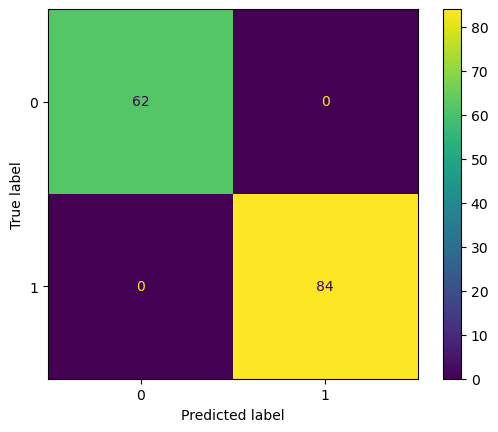

In [12]:
d.plot()

Create triton config

MAX_MEMORY_BYTES = 60_000_000
features = X_test.shape[1]
num_classes = pd.unique(y_test).size
bytes_per_sample = (features + num_classes) * 4
max_batch_size = MAX_MEMORY_BYTES // bytes_per_sample

import requests
r = requests.get('http://triton:8000/v2/models/small_model/versions/1/config')

r.content

def generate_config(encoded_model, deployment_type='gpu', storage_type='AUTO'):
    if deployment_type.lower() == 'cpu':
        instance_kind = 'KIND_CPU'
    else:
        instance_kind = 'KIND_GPU'

    config_text = f"""backend: "fil"
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {features} ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ {num_classes} ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "{storage_type}" }}
  }},
  {{
    key: "file:1/model.json"
    value: {{ string_value: "{encoded_model}" }}
  }}
]

dynamic_batching {{
  max_queue_delay_microseconds: 100
}}"""
    return config_text

def generate_config(encoded_model, instance_kind='KIND_GPU'):
    data = {
    	"name": "rf_anomaly",
    	"platform": "",
    	"backend": "fil",
    	"version_policy": {
    		"latest": {
    			"num_versions": 1
    		}
    	},
    	"max_batch_size": str(max_batch_size),
    	"input": [{
    		"name": "input__0",
    		"data_type": "TYPE_FP32",
    		"format": "FORMAT_NONE",
    		"dims": [str(features)],
    		"is_shape_tensor": "false",
    		"allow_ragged_batch": "false",
    		"optional": "false"
    	}],
    	"output": [{
    		"name": "output__0",
    		"data_type": "TYPE_FP32",
    		"dims": [str(num_classes)],
    		"label_filename": "",
    		"is_shape_tensor": "false"
    	}],
    	"batch_input": [],
    	"batch_output": [],
    	"optimization": {
    		"priority": "PRIORITY_DEFAULT",
    		"input_pinned_memory": {
    			"enable": "true"
    		},
    		"output_pinned_memory": {
    			"enable": "true"
    		},
    		"gather_kernel_buffer_threshold": 0,
    		"eager_batching": "false"
    	},
    	"dynamic_batching": {
    		"preferred_batch_size": [str(max_batch_size)],
    		"max_queue_delay_microseconds": 100,
    		"preserve_ordering": "false",
    		"priority_levels": 0,
    		"default_priority_level": 0,
    		"priority_queue_policy": {}
    	},
    	"instance_group": [{
    		"name": "rf_anomaly_0",
    		"kind": str(instance_kind),
    		"count": 1,
    		"gpus": [0],
    		"secondary_devices": [],
    		"profile": [],
    		"passive": "false",
    		"host_policy": ""
    	}],
    	"parameters": {
    		"output_class": {
    			"string_value": "true"
    		},
    		"storage_type": {
    			"string_value": "AUTO"
    		},
    		"threshold": {
    			"string_value": "0.5"
    		},
    		"model_type": {
    			"string_value": "xgboost_json"
    		},
    		"predict_proba": {
    			"string_value": "true"
    		}
    	},
    	"model_warmup": []
    }
    
    return data

Export model

model.save_model('model.json')
with open('model.json') as m:
    contents = m.read()
    encoded_model = base64.b64encode(contents.encode('utf-8'))

import os
REPO_PATH = os.path.abspath('/models')

def serialize_model(model, model_name):
    # The name of the model directory determines the name of the model as reported
    # by Triton
    model_dir = os.path.join(REPO_PATH, model_name)
    # We can store multiple versions of the model in the same directory. In our
    # case, we have just one version, so we will add a single directory, named '1'.
    version_dir = os.path.join(model_dir, '1')
    os.makedirs(version_dir, exist_ok=True)
    
    # The default filename for XGBoost models saved in json format is 'xgboost.json'.
    # It is recommended that you use this filename to avoid having to specify a
    # name in the configuration file.
    model_file = os.path.join(version_dir, 'xgboost.json')
    model.save_model(model_file)
    
    return model_dir

serialize_model(model, 'rf_anomaly')

config_text = generate_config(encoded_model)

In [13]:
triton_client = httpclient.InferenceServerClient(url='triton:8000')

In [38]:
triton_client.is_server_ready()

True

In [39]:
triton_client.is_model_ready('rf_anomaly')

True

Hot load model with JSON config

triton_client.load_model('rf_anomaly', config=json.dumps(config_text))

Inference

In [40]:
def triton_predict(model_name, arr):
    triton_input = httpclient.InferInput('input__0', arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = httpclient.InferRequestedOutput('output__0', class_count=1)
    response = triton_client.infer(model_name, model_version='1', inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy('output__0')

In [47]:
triton_result = triton_predict('rf_anomaly', df.loc[0:5].to_numpy().astype('float32'))

In [48]:
print(triton_result)

[[b'0.996987:1:anomalous']
 [b'0.996987:1:anomalous']
 [b'0.996882:0:normal\r']
 [b'0.996987:1:anomalous']
 [b'0.996882:0:normal\r']
 [b'0.996882:0:normal\r']]


Get protobuf file, persist model config

import tritonclient.grpc as grpcclient
triton_client = grpcclient.InferenceServerClient(url='triton:8001')
model_config = triton_client.get_model_config(model_name='rf_anomaly', model_version='1')

with open('/models/rf_anomaly/config.pbtxt', 'w') as f:
    f.write(str(model_config)[9:-2])

Kafka

In [29]:
!pip install kafka-python

In [30]:
import numpy as np

colnames = df.columns
df[colnames[::-1]]

In [80]:
producer = KafkaProducer(bootstrap_servers='kafka:9092')
num_records = 5
subset = df.loc[0:num_records]
for x in range(num_records+1):
    # send to morpheus
    producer.send('in', bytes(df.reset_index().loc[x].to_json(), 'utf-8'))
    # send to triton directly
    print(f"Triton: {triton_predict('rf_anomaly', np.expand_dims(df.loc[x].to_numpy().astype('float32'), 0))}")
    # local inference
    print(f"Local: {model.predict(df.loc[[x]])}")

Triton: [[b'0.996882:0:normal\r']]
Triton: [[b'0.996882:0:normal\r']]
Triton: [[b'0.996882:0:normal\r']]
Triton: [[b'0.996882:0:normal\r']]
Triton: [[b'0.996882:0:normal\r']]
Triton: [[b'0.996882:0:normal\r']]
